In [1]:
import numpy as np
import random
import os
import shutil

# ! pip install split-folders
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

rs = 42
def reset_random_seeds(rs):
   os.environ['PYTHONHASHSEED']=str(rs)
   tf.random.set_seed(rs)
   np.random.seed(rs)
   random.seed(rs)
reset_random_seeds(rs)

map_dir = 'map 5'

n=2
models =[]
histories =[]

remove prev saved database:

In [2]:
# only work for n=2
dir_path = './data/humanModel_v0_dataset'

for i in range(n):
    if os.path.exists(dir_path+'_split_'+str(i)):
        shutil.rmtree(dir_path+'_split_'+str(i))
    if os.path.exists(dir_path+"_"+str(i)):
        shutil.rmtree(dir_path+"_"+str(i))
    os.mkdir(dir_path+"_"+str(i))

for action in os.listdir(dir_path):
    os.mkdir(dir_path+'_'+str(0)+'/'+action)
    os.mkdir(dir_path+'_'+str(1)+'/'+action)
    for img in os.listdir(dir_path+'/'+action):
        if random.random() < 1/n:
            original = dir_path+'/'+action+'/'+img
            target = dir_path+'_'+str(0)+'/'+action+'/'+img
        else:
            original = dir_path+'/'+action+'/'+img
            target = dir_path+'_'+str(1)+'/'+action+'/'+img
        shutil.copyfile(original, target)


# Part 1 - Data Preprocessing

## Split into train , test data

In [3]:
# train, test split
for i in range(n):
    input = './data/humanModel_v0_dataset_'+ str(i)+ '/'
    output = "./data/humanModel_v0_dataset_split_"+ str(i)
    splitfolders.ratio(input=input, output=output, ratio=(0.8, 0.2))

Copying files: 2861 files [00:00, 17453.77 files/s]
Copying files: 2929 files [00:00, 16382.14 files/s]


### Preprocessing the Training set

In [4]:
batch_size = 64
IMG_SIZE = 10
datagen = ImageDataGenerator(rescale = 1./255)
trains = []
tests = []
for i in range(n):
    trains.append(datagen.flow_from_directory('./data/humanModel_v0_dataset_split_'+str(i)+'/train',
                                          target_size = (IMG_SIZE,IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse'))

    tests.append(datagen.flow_from_directory('./data/humanModel_v0_dataset_split_'+str(i)+'/val',
                                            target_size = (IMG_SIZE, IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse'))

Found 2287 images belonging to 5 classes.
Found 574 images belonging to 5 classes.
Found 2341 images belonging to 5 classes.
Found 588 images belonging to 5 classes.


## View some data

In [5]:
def build_model():
  num_classes = 5

  model = Sequential([
    layers.Conv2D(8, 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=[IMG_SIZE,IMG_SIZE,3]),
    layers.Conv2D(16, 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),# training=True),
    layers.Flatten(),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(num_classes, activation='softmax')
  ])
  return model

In [6]:
for i in range(n):
    models.append(build_model())

    models[i].compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print("fit {} ...".format(models[i]))
    epochs=200
    histories.append(models[i].fit(trains[i], validation_data=tests[i], epochs=epochs))
    # Save the entire model as a SavedModel.
    models[i].save('./data/'+map_dir+'/humanModel_'+ str(i) +'_v1.h5')

2022-05-12 20:24:27.406001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 20:24:27.410248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 20:24:27.410543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 20:24:27.411528: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

fit <keras.engine.sequential.Sequential object at 0x7fcaee10e150> ...


2022-05-12 20:24:28.003617: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/home/ido/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


Epoch 1/200


2022-05-12 20:24:28.547889: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2022-05-12 20:24:28.693689: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


36/36 [==============================] - 1s 14ms/step - loss: 1.6142 - accuracy: 0.3411 - val_loss: 1.5449 - val_accuracy: 0.3641
Epoch 2/200
36/36 [==============================] - 0s 10ms/step - loss: 1.5290 - accuracy: 0.3664 - val_loss: 1.4662 - val_accuracy: 0.3746
Epoch 3/200
36/36 [==============================] - 0s 10ms/step - loss: 1.4228 - accuracy: 0.4049 - val_loss: 1.3027 - val_accuracy: 0.4495
Epoch 4/200
36/36 [==============================] - 0s 10ms/step - loss: 1.2811 - accuracy: 0.4840 - val_loss: 1.1808 - val_accuracy: 0.5226
Epoch 5/200
36/36 [==============================] - 0s 10ms/step - loss: 1.1831 - accuracy: 0.5387 - val_loss: 1.1223 - val_accuracy: 0.6132
Epoch 6/200
36/36 [==============================] - 0s 10ms/step - loss: 1.0903 - accuracy: 0.6008 - val_loss: 1.0506 - val_accuracy: 0.6620
Epoch 7/200
36/36 [==============================] - 0s 11ms/step - loss: 1.0191 - accuracy: 0.6463 - val_loss: 0.9564 - val_accuracy: 0.7160
Epoch 8/200
36/36 

In [7]:
def eval(model, history, test):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    loss, accuracy = model.evaluate(test)
    print('Test accuracy :', accuracy)

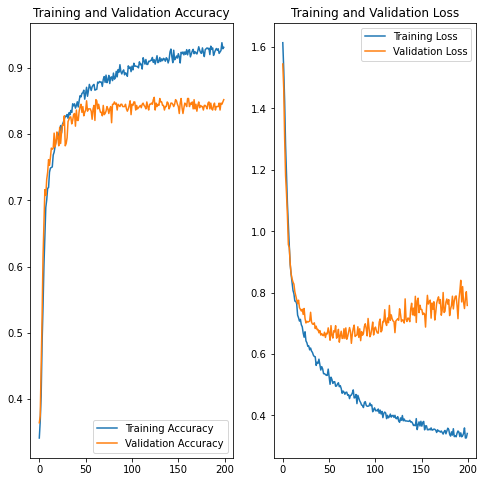

9/9 [==============================] - 0s 7ms/step - loss: 0.7583 - accuracy: 0.8519
Test accuracy : 0.8519163727760315


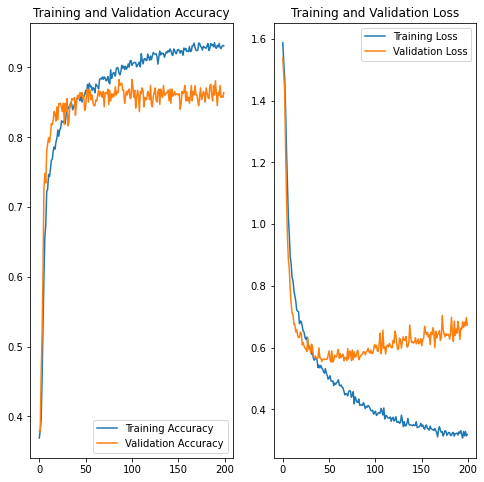

10/10 [==============================] - 0s 6ms/step - loss: 0.6726 - accuracy: 0.8639
Test accuracy : 0.8639456033706665


In [8]:
for i in range(n):
    eval(models[i], histories[i], tests[i])

### Predict on new data

In [10]:
path = "./data/humanModel_v0_dataset_split_0/val/38/-Ms8awdu1lzY0UvqZmyz_12.png"

img = keras.preprocessing.image.load_img(
    path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array = img_array/255

for i in range(n):
    predictions = models[i].predict(img_array)[0]

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(np.argmax(predictions), 100 * np.max(predictions))
    )



This image most likely belongs to 2 with a 99.98 percent confidence.
This image most likely belongs to 2 with a 100.00 percent confidence.
